# MTH 793P - Midterm Project - Adverserial Attack and Defence

"Deep Learning has achieved great success in various types of applications over recent years. On the other hand it has been found that deep neural networks (DNNs) can be easily fooled be adversarial input samples. This vulnerability raises major concerns in security-sensitive environments." - 
(Adversarial Attacks and Defenses Against Deep Neural Networks: A Survey, Mesut Ozdag, University of Central Florida

In this project, we trained three  neural networks on Intel Image Classification dataset on Kaggle to classify 6 different landscape images. Our goals are to build a powerful deep learning model that can identify the images with great accuracy and then see how the 3 models response to adversarial attack despite of having a high performance in normal cases.

To summarise, this was our high level approach:

1. We find a suitable model (trial and improvement)

  a. Fully Connected Network (model a)

  b. Convolutional Neural Network (Our Own Architecture, model b)

  c. Adaptation of AlexNet (Winner in ImageNet competition, model c)

2. We evaluate all models then refine as follows (respectively)

  a. Fully Connected - add more layers. Note, in our findings, after 4 fully connected layers, accuracy did not improve.

  b. Convolutional Neural Network - We modify drop out rate and show an increase in accuracy

  c. We perform scientific experiment with transfer learning - We observe inclusion of transfer learning as the better option (than without)

3. We perform the perturbation (white box) adversarial attack and test it on all three models. 

  These 3 models will be attacked and their accuracies noted. We show how model c is still more accurate even under attack scenarios.

4. We choose to progress with the best 2 of the 3 models. In this case we show why models b) and c) performed better under the attack and were therefore more interesting for the purpose of defence.

We shore up defences (in model b and c) by perturbing our training dataset for every 4 images such that: 25% of the images were perturbed. 

NOTE *We identified using steps in epsilon of 0.1 from 0 to 1 that epsilon = 0.1 provided the optimal defense (this experimentation was done on the fly, however can be verified by modifying epsilon within the defence cell - training_def())

5. We test the two best models (b and c) and note which performs best. In this report we show AlexNet adapted with Transfer Learning performed significantly better. 

6. For the CNN (our own architecture): As perturbation (epsilon) increased, convergence between the defended and undefended model was faster. 

However we show why for large perturbations, the Transfer learning model was superior (c) and for smaller perturbations the CNN (our own architecture performed better). 

This is our report.

## Usage Guideline:
This project is run on two different computers with the same GPU memory, 3GB. Due to the limitation in hardware (GPU memory specifically), we ran the models on three different notebooks initially. Then to make the report presentable, we merged all three notebooks into one and run on different occasions. These are the steps we used for other users who have hardware limitation like us and wish to replicate our work on this notebook. The report is split into two two independent sections. 

### Model Training, Testing and Adversarial Attack:

- Step 1: Run all the visualisation and data processing. Then train, test and run attack(let call this 'perform the model') on Fully Connected model (declare as 'fully' variable) and save the attack result to a csv file
- Step 2: Clear GPU memory* and perform the Convolution model (declare as 'convo' variable') and save the attack result to a csv file
- Step 3: Clear GPU memory* and perform the Transfer Learning model (declare as 'model_trans' variable') and save the attack result to a csv file
- Step 4: Use the result of adversarial attack of Transfer Learning model(do not restart the memory after step3) to create adversarial attack example

### Defending Adversarial Attack using Adversarial Training:
- Step 1: Run all functions for training and testing the defend
- Step 2: Run Transfer Learning model (declare as 'trans_def') then train and test it
- Step 3: Clear GPU memory* and then perform the Convolutional model (declear as 'convo_def') like step 2

<font size="2"><i> * we tried to run the 'reset' button on Kernel tab at first but it did not clear the memory from the GPU for us. So we close Jupyter Notebook to clear the memory<i></font>

## Dataset: Intel Image Classification
The dataset is the [Intel Image Classification](https://www.kaggle.com/puneet6060/intel-image-classification) containing around 25,000 images with 6 categories. The dataset is seperated into three sets: train, test and prediction. For this project, we are only interested in the train and test sets because there are no labels in the prediction. Hence, we ran our model using around 14,000 images in train and 3,000 in test 

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import *
import PIL

In [0]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [0]:
#Image transformation and Data Augmentation
transform_train= transforms.Compose([transforms.Resize((150,150)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(degrees=20),
                                    transforms.ColorJitter(),
                                    transforms.CenterCrop(size=150),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#random hori flip is one kind of data augmentation, flip some random images horizontally 

transform_test= transforms.Compose([transforms.Resize((150,150)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#no need data augmentation for the testing data

#load images from the directories
train= datasets.ImageFolder('Data/seg_train', transform= transform_train)
test= datasets.ImageFolder('Data/seg_test', transform= transform_test)

#running data iterators
batch_size=128
train_loader= DataLoader(train,batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test,batch_size=1, shuffle=True)

## Data Exploration
We want to analyse what the dataset contains. There are 6 different classes and we have no issues with missing data and class imbalance. This is the architecture of how we organise the data folders:

&nbsp; /Data <br>
&ensp; /seg_train <br>
&emsp; /class1 <br>
&emsp; /class2 <br>
&emsp; . <br>
&ensp; /seg_test <br>
&emsp; /class1 <br>
&emsp; /class2 <br>
&emsp; .

This is a conventional organisation of the data for Deep Neural Network for image recognition and make it easier to mark the correct label for each image

To understand the data better we visualised what we were aiming to achieve - and it looks cool

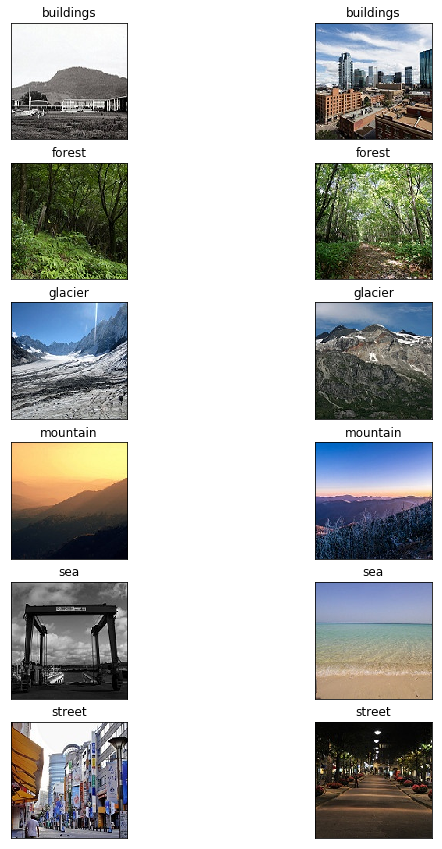

In [0]:
from matplotlib import pyplot as plt
from PIL import Image
from glob import glob
import os

train_path='Data/seg_train'
test_path='Data/seg_train'
folders = os.listdir(train_path)
images = []
labels = []
for cl in folders:
    path = os.path.join('Data/seg_train', cl, '*.jpg')
    for file in glob(path)[:2]:
        with Image.open(file) as f:
            images.append(np.array(f))
            labels.append(cl)
            
fig = plt.figure(figsize=(10, 15))

for i, image in enumerate(images):
    ax = fig.add_subplot(6, 2, i+1)
    ax.imshow(image)
    ax.set_title(labels[i])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

The number of traning samples for buildings:  2191
The number of traning samples for forest:  2271
The number of traning samples for glacier:  2404
The number of traning samples for mountain:  2512
The number of traning samples for sea:  2274
The number of traning samples for street:  2382


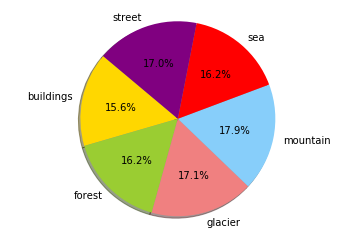

In [0]:
total =0
#these are the classifications
#how many of each classifications do we have?

#pretty balanced even distributions of classifications
#random would be 1/6 so it's not out of wack

#CLASSIFICATION DICTIONARY
#'buildings'  -> 0,
#'forest'     -> 1,
#'glacier'    -> 2,
#'mountain'   -> 3,
#'sea'        -> 4,
#'street'     -> 5

counter_classifications = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}

for data in train_loader:
    Xs, ys = data
    for y in ys:
        counter_classifications[int(y)]+=1
        total+=1
        
#counter
print('The number of traning samples for buildings: ', counter_classifications[0])
print('The number of traning samples for forest: ', counter_classifications[1])
print('The number of traning samples for glacier: ', counter_classifications[2])
print('The number of traning samples for mountain: ', counter_classifications[3])
print('The number of traning samples for sea: ', counter_classifications[4])
print('The number of traning samples for street: ', counter_classifications[5])

labels = 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'
sizes = [counter_classifications[0],counter_classifications[1],counter_classifications[2],counter_classifications[3],counter_classifications[4], counter_classifications[5]]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red', 'purple']

# Plot
plt.pie(sizes, explode=None, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

- The pie chart above shows that the class distribution is fairly even. Therefore, we have no issue with class imbalance

## Image Preprocessing:
To make the images fit into our network, we resized and normalised each color channel. Firstly, we resized all images to 150 x 150 as it is the standard given by the dataset description. Secondly, the range of each color channel is already between 0 and 1 via transforms.ToTensor() and then we normalised by subtracting a mean value and dividing by a standard deviation. The values for the mean and standard deviation in this case is 0.5 which we adopted from the usual practice of deep learning community. In this stage, we also augmented the train set as a technique to reduce overfitting

### Data Augmentation:
To expand data coverage, random transformations were applied to each epoch (while training), so the network became trained on many different versions of the same image. Data was converted to Torch Tensors before normalization. Testing data is not augmented but is only resized and normalized. The normalization values are standardized. Data Iterators The RAM requirements of loading all the data at once is too high. Therefore we adopt DataLoaders. A dataset object is created using ImageFolder and then passed into DataLoader. To train we iterate rather than load all at once by calling the DataLoader with batch size 128

We will see some examples of how data augmentation is applied bellow:

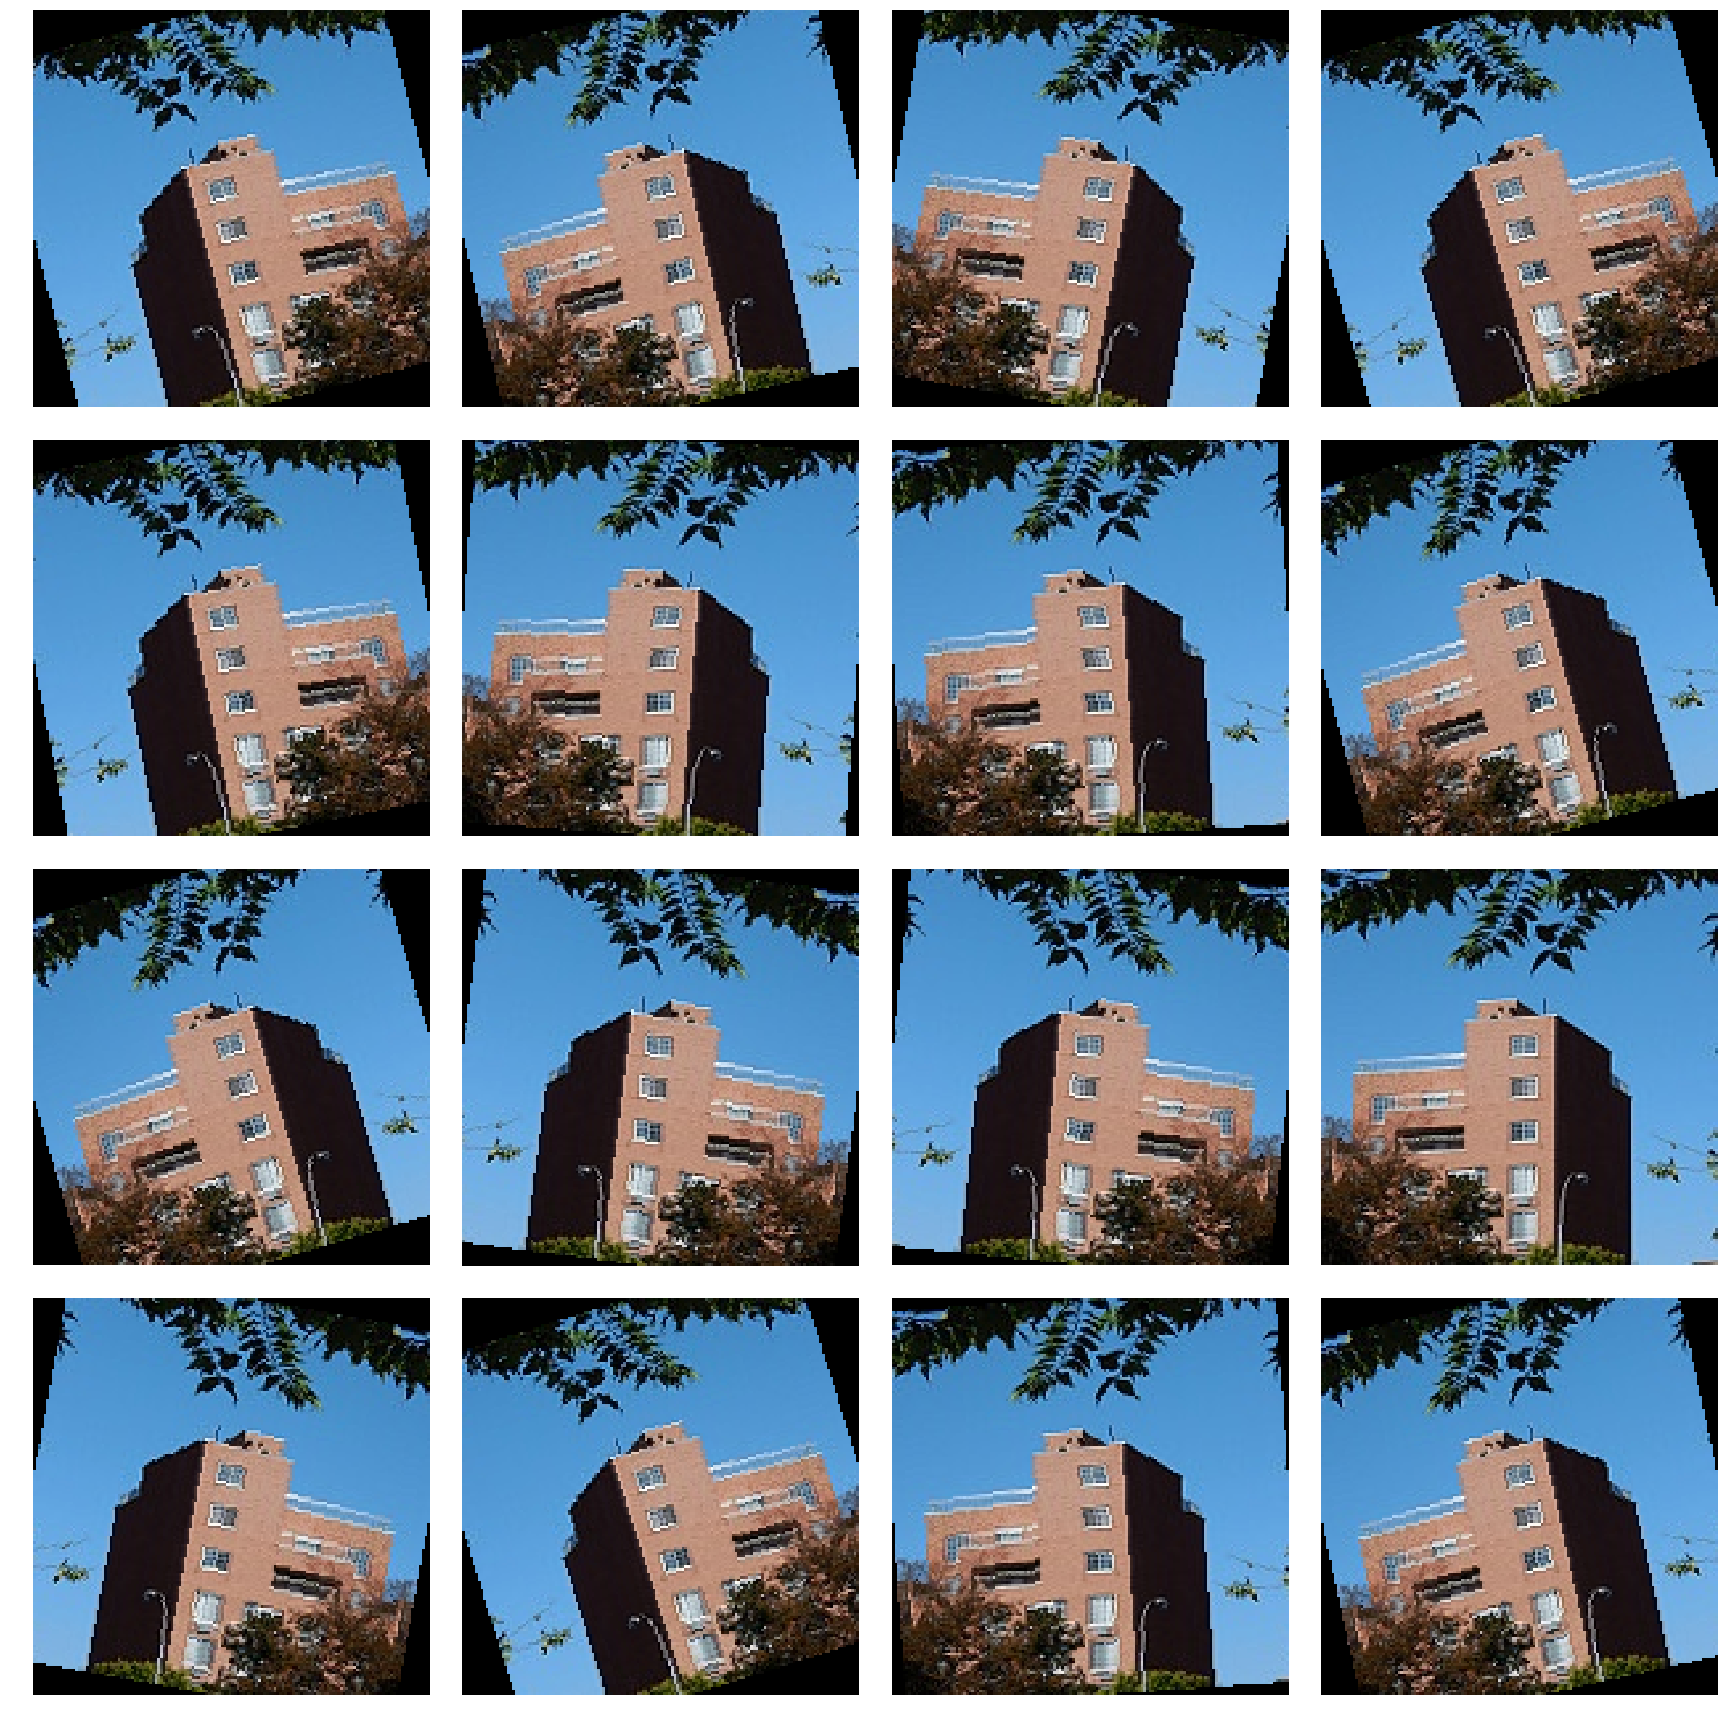

In [0]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

ex_img = Image.open('Data/seg_train/buildings/3328.jpg')
img_trans = transform_train
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(img_trans(ex_img), ax=ax)

plt.tight_layout()
plt.savefig('data_aug.png')

## Models:
The nature of this exercise was a scientific one. Theory of CNNs, FCN is relatively new and therefore we used 3 approaches and also used Emperical evidence available on various sources in Kaggle community. 

The three approaches were:

* Fully connected
* Convoluted (our own network) 
* AlexNet (Convolutional and Fully Connected with Transfer Learning)

NN Selection: We tried an initial 4 layer Fully Connected Networks and despite trying more layers, there was minimal improvement therefore we did not include these additional models.

### Activation Functions
In the neural network, we generate a single neuron by summing up the products of inputs and their corresponding weights and adding a bias:
$$z= \sum\langle  {x}_i,w \rangle+ bias$$ 
If we leave our network like this in every layer, the model will be just a simple linear regression, which is well-known as a model with limited performance. Hence, this is why Activation Function is being in in neural network.

#### Sigmoid

![alt text](https://hvidberrrg.github.io/deep_learning/activation_functions/assets/sigmoid_function.png) 

$$\sigma  (x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-x}}  $$ 

This activation function is a S-shaped curve and generate outputs between 0 and 1. It is easy to understand and apply but it has some major issues which make this function unpopular. One of the problems is the output is not centered around 0 which causes the optimisation harder for the next layer. Hence, **Hyperbolic Tangent Function- Tanh** is introduced to solve this problem

#### Tanh
![alt text](https://www.i2tutorials.com/wp-content/uploads/2019/09/Deep-learning-22-i2tutorials.png)
$$tanh(x)= \frac{e^x-e^{-x}}{e^x+e^{-x}} $$

Mathematically, this function is a shifted version of the sigmoid as this changes the range of the output to between -1 and 1 from between 0 and 1. However, Tanh and Sigmoid functions suffer the same issue with Vanishing gradient problem. For a small or large output, the gradients of these functions are close to 0 and this slows down gradient descent. This is where **Rectified Linear units- RELu** comes in to solve 


#### RELU
![alt text](https://miro.medium.com/max/1026/0*g9ypL5M3k-f7EW85.png)
$$max(0,w^{T}x+b)$$

The mathematical form shows that this function is simple and computationally effective. It helps to avoid and rectify the vanishing problem. This makes them become the most used function for Deep Learning. 

Nevertheless, RELu is not perfect. When the linear output is negative, the gradient of this activation function becomes zero and can not perform backpropagation, which is known as the Dying RELu problem. This problem can be solved by using **Leaky RELu** but the problem is trivial practically. Therefore, we still apply RELu for our models. 

Another limitation of RELu is that it can work best in hidden layers of a Neural Network. So we need to use a different function for the output layer

#### Softmax
$$\sigma(z)_j=\frac{e^{z_j}}{ \sum\nolimits_{k=1}^{K}e^{z_j} }$$
for j=1,2,...,k

Softmax is a more generalized version of the logistic sigmoid function and well-known for multi-class classification. 

We utilised the Softmax classifier for the final layer of the 6 different categories.

### Techniques to reduce overfitting
In this project, we apply two technique to combat overfitting:
- Data Augmentation (mention above)
- Dropout

#### Dropout:
When we add more layers in Neural Networks, we can improve the models performance but also increase the risk that our models is fitted in the train set too well. Therefore, we apply a popular and simple techique called Dropout to avoid overfitting in our models. Dropout is to set some neuron hidden in a layer randomly with a probability as a hyperparameter. The neurons dropped out have outputs of zero and hence, do not contribute to the forward pass and do no participate in the back-propagation. Then everytime an input is passed through, the model generates a different architecture. Thus, this techique reduces the model's complexity and then avoids overfitting



![alt text](https://www.researchgate.net/profile/Amine_Ben_khalifa/publication/309206911/figure/fig3/AS:418379505651712@1476760855735/Dropout-neural-network-model-a-is-a-standard-neural-network-b-is-the-same-network.png)

### Fully Connected Neural Networks 
We tried an initial 4 layer Fully Connected Networks and despite trying more layers, there was minimal improvement therefore we did not include these additional models. <br>
<br>
The structure of this model is:
- Fully connected layer 1: (150x150x3) (the image size times the number of color channels) input nodes and 64 output nodes
- Fully connected layers 2 and 3: 64 input nodes and 64 output nodes
- Fully connected layers 4: 64 input nodes and 6 output nodes representing for the number of classes

In [0]:
#Models: Fully Connected and Convolution

class fully(nn.Module):
    def __init__(self):
        super().__init__()#initialises the inherited methods from the parent class
        #fc stands for fully connected
        #the first layer is the input and the last layer is the output
        self.fc1 = nn.Linear(150*150*3, 64) #create a self connected fully connected neural network (linear). 150*150 is
        self.fc2 = nn.Linear(64, 64) #the size of the flattened image. 256 is the output. Can be anything we want
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 6)
        
    
    #to pass the parameters to feed them through the neural network with activation function to normalise and keep it all between 
    #1 and 0. We use Relu here to prevent the numbers getting to ridiculously strange values (prevent loss explosion)
    #we have 6 options and we want only one to be selected. The rest need to be off. Or for example we want a distribution
    #where each output will have a probability on the output. For this we use logs of softmax function
    
    # we can put logic into here but this is all imagery
    def forward(self, x):
        x = F.relu(self.fc1(x)) # relu will keep output from these neural network layers exploding.
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x) # no need to conduct relu on the output layer of course
        return F.log_softmax(x, dim=1) # dim 1 we want the output layer to be added to 1. 
                                       # distributes the this will compute the loss between 
fully = fully().to(device)

### Convolutional Neural Networks
Our second model applies convolutional layers to work with images. This is one of the most popular techniques in Computer Vision recently as it helps to improved Neural Networks model's performance significantly. 

We tried to construct our models heuristically. Due to computational time, we can only include the final CNN we built in this report. The model has 5 layers, 2 convolutional layers and 3 classifier layers:
- Covolutional layer 1: 128 convolutional filers with a kernel size of 5 and stride 2. This is followed by a max pooling with a kernel size of 2 and stride 2
- Covolutional layer 2: 256 convolutional filers with a kernel size of 5 and stride 2. This is followed by a max pooling with a kernel size of 2 and stride 2
- Classifier layer 1: RELu with 16384 input nodes (flattened size of the data matrix after going through the convolutional layers) and 1024 output nodes
- Classifier layer 2: RELu with 1024 input nodes (previous layer's output nodes) and 1024 output nodes.
- Classifier layer 3: Softmax with 1024 input nodes and 6 output nodes representing for the number of classes


In [0]:
class convo(nn.Module):
    def __init__(self):
        super().__init__() 
       
        self.layer1= nn.Sequential(
            nn.Conv2d(3,128,kernel_size=5,stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        
        self.layer2= nn.Sequential(
            nn.Conv2d(128,256,kernel_size=5,stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        
        #self.dropout1= nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(16384, 1024)
        #self.dropout2= nn.Dropout2d(p=0.3)
        self.fc2 = nn.Linear(1024, 1024) 
        #self.dropout3= nn.Dropout2d(p=0.5)
        self.fc3 = nn.Linear(1024,6)
            
    def forward(self,x):
        x= self.layer1(x)
        x= self.layer2(x)
        #x= self.dropout1(x)
        x= x.reshape(x.size(0), -1)
        x= F.relu(self.fc1(x))
        #x= self.dropout2(x)
        x= F.relu(self.fc2(x))
        #x= self.dropout3(x)
        x= self.fc3(x)
        return F.log_softmax(x, dim=1)
    
convo= convo().to(device)

### Transfer Learning: AlexNet
We wanted to improve our second model by adding more convolutional layers. However, we have limited resources, the hardwares and this keep us from training a more complicated model. Therefore, we changed our approach to use a pre-trained model with a great performance and then customise it to be fit with our dataset. This method is called 'Transfer Learning' and it is one of the popular practice applied by the Deep Learning community.

The reason why for Transfer Learning works is that the convolution layers of a CNN extract relevant features for many image recognition problems. And the classifier layers are to specialise to a specific dataset. Therefore, we can choose to pre-trained CNN model, keep its convolutional layers and then train the classifier layers on our dataset. <br>
<br>
Our choice in this case is a model named AlexNet as it ranked the first in ImageNet Challenge 2012 ([@source](https://pytorch.org/docs/stable/torchvision/models.html))

Transfer Learning consists of 4 steps:


1.   Load in pre-trained weights from the chosen model
2.   Freeze all the weights
3. Change the current model's classifier layers to a custom layers
4. Train the custom layers using our train set to perform the task


In [0]:
#Transfer Learning

#we will apply transfer learning
#we use AlexNet, the top 1 performance in ImageNet
from torchvision import models
model_trans = models.alexnet(pretrained=True).to(device)
#freeze model weights
for param in model_trans.parameters():
    param.requires_grad = False
    
model_trans.classifier #to know how many classiers there are then we aim to change and train the last layers

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [0]:
n_inputs= model_trans.classifier[6].in_features #find out the number of inputs for our custom layer

#adding custom classifier
model_trans.classifier[6]= nn.Sequential(
        nn.Linear(n_inputs, 4096), nn.ReLU(), nn.Dropout(0.4),
        nn.Linear(4096, 6), nn.LogSoftmax(dim=1))

model_trans.classifier #print out the final framework

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=4096, out_features=6, bias=True)
    (4): LogSoftmax()
  )
)

In [0]:
model_trans

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Model Training

### Optimiser: Adam
**Adam or Adaptive Momentum** alogrithm is an alternative optimisation method to **Stochastic Gradient Descent**. This alogrithm is a combination of two optimisation methods, **Momentum**([Wiki](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum)) and **Root Mean Square Propagation or RMSProp**([Wiki](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp)). These are the update formulas of Adam optimiser:

$$\nu_t = \beta_1*\nu_{t-1}-(1-\beta_1)*g_t$$
$$s_t= \beta_2*s_{t-1}-(1-\beta_2)*g^{2}_{t}$$
$$\bigtriangleup{w_t}=  \eta \frac{\nu_t}{ \sqrt{s_t+ \epsilon } }*g_t $$
$$w_{t+1}=w_t+\bigtriangleup{w_t}$$
where: <br>
$\eta$: Initial Learning Rate <br>
$g_t$: Gradient at time $t$ along $w_j$ <br>
$\nu_t$: Exponential Average of gradients along $w_j$  <br>
$s_t$: Exponential Average of squares of gradients along $w_j$ <br>
$\beta_1, \beta_2$: Hyperparameters

Throughout the project we tested both SGD and Adam Optimisers and we had a better result with the latter method with given batch size and epoch. However, due to time constrain, we only include the results using Adam optimiser in this report. 

In [0]:
#define epochs, loss func and optimiser
epochs= 15
criterion= nn.NLLLoss()

def training(model):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()
    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            #let variables run on GPU
            x,y=x.to(device), y.to(device)
            # Run the forward pass
            yhat = model(x)
            loss = criterion(yhat, y)
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = y.size(0)
            predicted= torch.argmax(yhat, axis=1)
            correct = (predicted == y).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 55 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 100))
                
def training_fc(model): #to run on fully connected specifically
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()
    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    for epoch in range(epochs):
        for i, (x, y) in enumerate((train_loader)):
            #let variables run on GPU
            x,y=x.to(device), y.to(device)
            # Run the forward pass
            yhat = model(x.view(-1,150*150*3))
            loss = criterion(yhat, y)
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = y.size(0)
            predicted= torch.argmax(yhat, axis=1)
            correct = (predicted == y).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 55 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 100))
                


In [0]:
training_fc(fully)

Epoch [1/15], Step [55/110], Loss: 1.2600, Accuracy: 49.22%
Epoch [1/15], Step [110/110], Loss: 1.3152, Accuracy: 48.78%
Epoch [2/15], Step [55/110], Loss: 1.2546, Accuracy: 54.69%
Epoch [2/15], Step [110/110], Loss: 1.0334, Accuracy: 68.29%
Epoch [3/15], Step [55/110], Loss: 1.2229, Accuracy: 51.56%
Epoch [3/15], Step [110/110], Loss: 1.2132, Accuracy: 50.00%
Epoch [4/15], Step [55/110], Loss: 1.1019, Accuracy: 54.69%
Epoch [4/15], Step [110/110], Loss: 1.2704, Accuracy: 50.00%
Epoch [5/15], Step [55/110], Loss: 0.9856, Accuracy: 64.06%
Epoch [5/15], Step [110/110], Loss: 1.2668, Accuracy: 54.88%
Epoch [6/15], Step [55/110], Loss: 0.9414, Accuracy: 58.59%
Epoch [6/15], Step [110/110], Loss: 0.9997, Accuracy: 58.54%
Epoch [7/15], Step [55/110], Loss: 1.0731, Accuracy: 55.47%
Epoch [7/15], Step [110/110], Loss: 1.1297, Accuracy: 58.54%
Epoch [8/15], Step [55/110], Loss: 0.9836, Accuracy: 64.84%
Epoch [8/15], Step [110/110], Loss: 1.0354, Accuracy: 56.10%
Epoch [9/15], Step [55/110], Los

In [0]:
training(convo)

Epoch [1/15], Step [55/110], Loss: 1.1099, Accuracy: 56.25%
Epoch [1/15], Step [110/110], Loss: 1.1430, Accuracy: 57.32%
Epoch [2/15], Step [55/110], Loss: 0.7947, Accuracy: 67.19%
Epoch [2/15], Step [110/110], Loss: 0.7545, Accuracy: 73.17%
Epoch [3/15], Step [55/110], Loss: 0.7806, Accuracy: 67.97%
Epoch [3/15], Step [110/110], Loss: 0.7742, Accuracy: 71.95%
Epoch [4/15], Step [55/110], Loss: 0.7714, Accuracy: 71.09%
Epoch [4/15], Step [110/110], Loss: 0.6237, Accuracy: 73.17%
Epoch [5/15], Step [55/110], Loss: 0.5027, Accuracy: 81.25%
Epoch [5/15], Step [110/110], Loss: 0.5439, Accuracy: 84.15%
Epoch [6/15], Step [55/110], Loss: 0.7513, Accuracy: 70.31%
Epoch [6/15], Step [110/110], Loss: 0.5535, Accuracy: 75.61%
Epoch [7/15], Step [55/110], Loss: 0.5225, Accuracy: 78.91%
Epoch [7/15], Step [110/110], Loss: 0.6965, Accuracy: 78.05%
Epoch [8/15], Step [55/110], Loss: 0.4072, Accuracy: 85.16%
Epoch [8/15], Step [110/110], Loss: 0.5697, Accuracy: 78.05%
Epoch [9/15], Step [55/110], Los

In [0]:
model_trans= model_trans.to(device)
training(model_trans)

Epoch [1/15], Step [55/110], Loss: 0.4745, Accuracy: 83.59%
Epoch [1/15], Step [110/110], Loss: 0.5138, Accuracy: 76.83%
Epoch [2/15], Step [55/110], Loss: 0.5661, Accuracy: 75.78%
Epoch [2/15], Step [110/110], Loss: 0.5142, Accuracy: 81.71%
Epoch [3/15], Step [55/110], Loss: 0.3805, Accuracy: 85.94%
Epoch [3/15], Step [110/110], Loss: 0.5610, Accuracy: 79.27%
Epoch [4/15], Step [55/110], Loss: 0.3688, Accuracy: 85.94%
Epoch [4/15], Step [110/110], Loss: 0.4088, Accuracy: 81.71%
Epoch [5/15], Step [55/110], Loss: 0.2450, Accuracy: 91.41%
Epoch [5/15], Step [110/110], Loss: 0.4286, Accuracy: 86.59%
Epoch [6/15], Step [55/110], Loss: 0.4287, Accuracy: 79.69%
Epoch [6/15], Step [110/110], Loss: 0.2416, Accuracy: 90.24%
Epoch [7/15], Step [55/110], Loss: 0.4107, Accuracy: 85.94%
Epoch [7/15], Step [110/110], Loss: 0.4065, Accuracy: 84.15%
Epoch [8/15], Step [55/110], Loss: 0.3797, Accuracy: 81.25%
Epoch [8/15], Step [110/110], Loss: 0.4411, Accuracy: 81.71%
Epoch [9/15], Step [55/110], Los

## Model Testing

In [0]:
def test_con(model):
    model.eval()
    correct = 0
    total = 0
    for key, dataset in {"Train set": train_loader, "Test set": test_loader}.items():
        with torch.no_grad():
            for (x,y) in dataset:
                x, y = x.to(device), y.to(device)
                output = model(x)
                for idx, i in enumerate(output):
                    if torch.argmax(i) ==y[idx]:
                        correct += 1
                    total += 1
        acc=(correct/total)*100
        print(f"Accuracy of {key}: {acc:.2f}%")
        
def test_fc(model): #specific model for fully connected
    correct = 0
    total = 0
    for key, dataset in {"Train Set": train_loader, "Test Set": test_loader}.items():
        with torch.no_grad():
            for (x,y) in dataset:
                x, y = x.to(device), y.to(device)
                output = model(x.view(-1,150*150*3))
                for idx, i in enumerate(output):
                    if torch.argmax(i) ==y[idx]:
                        correct += 1
                    total += 1
        acc=(correct/total)*100
        print(f"Accuracy of {key}: {acc:.2f}%")

In [0]:
test_fc(fully)

Accuracy of Train Set: 66.62%
Accuracy of Test Set: 65.68%


In [0]:
test_con(convo)

Accuracy of Train set: 85.40%
Accuracy of Test set: 84.81%


In [0]:
test_con(model_trans)

Accuracy of Train set: 91.20%
Accuracy of Test set: 90.57%


As we expected, the performances increased from the first to the third models. Moreover, the results also show that convolutional neural network is superior to fully connected neural network regard to image recognition problems. And it is surprising that the transfer learning model with weighted pre-trained from a more complex model and large dataset only helped to get a slight increase in the accuracy. 

<font size="2"><i> * after the presentation, we re-trained the models for several times to implement new things in our reports such as Adversarial Attacks on all three models and a Defense method. We did not include any seed in our randomisation so that the some test results are different from the ones shown in the presentation slides due to variation.<i></font>

## Adversarial Attack
Despite of the great performances that our model achieved, we wanted to see how they responsed to other technical practices designed to fool them. There are two techniques to attack a Neural Network model. The first is a white-box attack, which an attacker has a full knownledge and access to the inputs and model. The second is a black-box attack, which an attack only has access to the inputs and outputs. <br>
In this project, we applied the white-box approach since we already had access to the models. And our choice of attack is Fast Gradient Sign Method

#### Fast Gradient Sign Method
**Fast Gradient Sign Method or FGSM** adjusts input data to maximise the loss based on the same backpropagated gradient. Its formula is:
$$x^{adv}= x+ \varepsilon ( \bigtriangledown_x J(x,y_{true}))$$
where <br>
$x$: the input image <br>
$x^{adv}$: the perturbed adversarial image <br>
$J$: the classification loss function
$y_{true}$: the true label of input $x$

Epsilon is the hyper parameter to determent in this case so a vector is created of the different levels of epsilon we trial for the purposes of perturbation. After 0.8 the change in accuracy is nearly flat therefore to speed up run time, we have ended at 0.8 and not higher. 

#### Fast Gradient Sign Method
**Fast Gradient Sign Method or FGSM** adjusts input data to maximise the loss based on the same backpropagated gradient. Its formula is:
$$x^{adv}= x+ \varepsilon ( \bigtriangledown_x J(x,y_{true}))$$
where <br>
$x$: the input image <br>
$x^{adv}$: the perturbed adversarial image <br>
$J$: the classification loss function
$y_{true}$: the true label of input $x$

Epsilon is the hyper parameter to determent in this case so a vector is created of the different levels of epsilon we trial for the purposes of perturbation. After 0.8 the change in accuracy is nearly flat therefore to speed up run time, we have ended at 0.8 and not higher. 


In [ ]:
# FGSM attack code
epsilons = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65,.7, .75, .8]
use_cuda=True

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [0]:
#test function

def test_ad( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        if model == fully:
            data= data.view(-1,150*150*3) #for fully connected model
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        #init_pred = init_pred.view(-1)
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [0]:
#run attack for each model
#fully connected
acc_fc = []
eg_fc = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_ad(fully, device, test_loader, eps)
    acc_fc.append(acc)
    eg_fc.append(ex)
    

Epsilon: 0	Test Accuracy = 844 / 3000 = 0.2813333333333333
Epsilon: 0.05	Test Accuracy = 503 / 3000 = 0.16766666666666666
Epsilon: 0.1	Test Accuracy = 277 / 3000 = 0.09233333333333334
Epsilon: 0.15	Test Accuracy = 185 / 3000 = 0.06166666666666667
Epsilon: 0.2	Test Accuracy = 120 / 3000 = 0.04
Epsilon: 0.25	Test Accuracy = 85 / 3000 = 0.028333333333333332
Epsilon: 0.3	Test Accuracy = 68 / 3000 = 0.02266666666666667
Epsilon: 0.35	Test Accuracy = 56 / 3000 = 0.018666666666666668
Epsilon: 0.4	Test Accuracy = 43 / 3000 = 0.014333333333333333
Epsilon: 0.45	Test Accuracy = 42 / 3000 = 0.014
Epsilon: 0.5	Test Accuracy = 39 / 3000 = 0.013
Epsilon: 0.55	Test Accuracy = 44 / 3000 = 0.014666666666666666
Epsilon: 0.6	Test Accuracy = 42 / 3000 = 0.014
Epsilon: 0.65	Test Accuracy = 43 / 3000 = 0.014333333333333333
Epsilon: 0.7	Test Accuracy = 42 / 3000 = 0.014
Epsilon: 0.75	Test Accuracy = 44 / 3000 = 0.014666666666666666
Epsilon: 0.8	Test Accuracy = 42 / 3000 = 0.014


In [0]:
df_fc = pd.DataFrame(data={"acc": acc_fc, "eg": eg_fc})
df_fc.to_csv("ad_atk_fc.csv", sep=',',index=False)

In [0]:
#convolution
acc_convo = []
eg_convo = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_ad(convo, device, test_loader, eps)
    acc_convo.append(acc)
    eg_convo.append(ex)

Epsilon: 0	Test Accuracy = 921 / 3000 = 0.307
Epsilon: 0.05	Test Accuracy = 500 / 3000 = 0.16666666666666666
Epsilon: 0.1	Test Accuracy = 381 / 3000 = 0.127
Epsilon: 0.15	Test Accuracy = 346 / 3000 = 0.11533333333333333
Epsilon: 0.2	Test Accuracy = 344 / 3000 = 0.11466666666666667
Epsilon: 0.25	Test Accuracy = 311 / 3000 = 0.10366666666666667
Epsilon: 0.3	Test Accuracy = 289 / 3000 = 0.09633333333333334
Epsilon: 0.35	Test Accuracy = 257 / 3000 = 0.08566666666666667
Epsilon: 0.4	Test Accuracy = 219 / 3000 = 0.073
Epsilon: 0.45	Test Accuracy = 194 / 3000 = 0.06466666666666666
Epsilon: 0.5	Test Accuracy = 171 / 3000 = 0.057
Epsilon: 0.55	Test Accuracy = 165 / 3000 = 0.055
Epsilon: 0.6	Test Accuracy = 161 / 3000 = 0.05366666666666667
Epsilon: 0.65	Test Accuracy = 159 / 3000 = 0.053
Epsilon: 0.7	Test Accuracy = 153 / 3000 = 0.051
Epsilon: 0.75	Test Accuracy = 149 / 3000 = 0.049666666666666665
Epsilon: 0.8	Test Accuracy = 145 / 3000 = 0.04833333333333333


In [0]:
df_convo = pd.DataFrame(data={"acc": acc_convo, "eg": eg_convo})
df_convo.to_csv("ad_atk_convo.csv", sep=',',index=False)

In [0]:
#transfer learning
acc_trans = []
eg_trans = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_ad(model_trans, device, test_loader, eps)
    acc_trans.append(acc)
    eg_trans.append(ex)

Epsilon: 0	Test Accuracy = 2128 / 3000 = 0.7093333333333334
Epsilon: 0.05	Test Accuracy = 1233 / 3000 = 0.411
Epsilon: 0.1	Test Accuracy = 944 / 3000 = 0.31466666666666665
Epsilon: 0.15	Test Accuracy = 808 / 3000 = 0.2693333333333333
Epsilon: 0.2	Test Accuracy = 735 / 3000 = 0.245
Epsilon: 0.25	Test Accuracy = 696 / 3000 = 0.232
Epsilon: 0.3	Test Accuracy = 682 / 3000 = 0.22733333333333333
Epsilon: 0.35	Test Accuracy = 666 / 3000 = 0.222
Epsilon: 0.4	Test Accuracy = 660 / 3000 = 0.22
Epsilon: 0.45	Test Accuracy = 644 / 3000 = 0.21466666666666667
Epsilon: 0.5	Test Accuracy = 630 / 3000 = 0.21
Epsilon: 0.55	Test Accuracy = 620 / 3000 = 0.20666666666666667
Epsilon: 0.6	Test Accuracy = 611 / 3000 = 0.20366666666666666
Epsilon: 0.65	Test Accuracy = 618 / 3000 = 0.206
Epsilon: 0.7	Test Accuracy = 618 / 3000 = 0.206
Epsilon: 0.75	Test Accuracy = 628 / 3000 = 0.20933333333333334
Epsilon: 0.8	Test Accuracy = 601 / 3000 = 0.20033333333333334


In [0]:
df_trans = pd.DataFrame(data={"acc": acc_trans, "eg": eg_trans})
df_trans.to_csv("ad_atk_trans.csv", sep=',',index=False)

In [0]:
import pandas as pd
df_fc= pd.read_csv('ad_atk_fc.csv')
df_convo= pd.read_csv('ad_atk_convo.csv')
df_trans= pd.read_csv('ad_atk_trans.csv')

acc_fc= df_fc['acc']
acc_convo= df_convo['acc']
acc_trans= df_trans['acc']

epsilons = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65,.7, .75, .8]

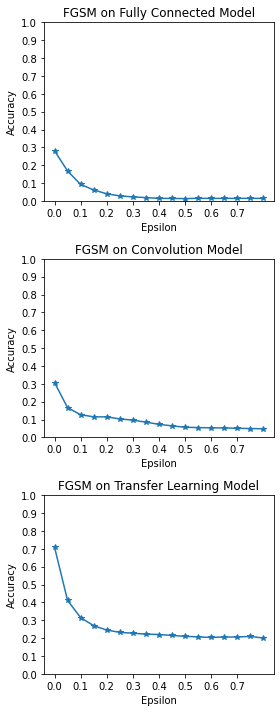

In [0]:
#plot accuracy vs epsilon
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(4,10))
plt.subplot(3,1,1)
plt.plot(epsilons, acc_fc, "*-")
plt.title('FGSM on Fully Connected Model')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.8, step=0.1))
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

plt.subplot(3,1,2)
plt.plot(epsilons, acc_convo, "*-")
plt.title('FGSM on Convolution Model')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.8, step=0.1))
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

plt.subplot(3,1,3)
plt.plot(epsilons, acc_trans, "*-")
plt.title('FGSM on Transfer Learning Model')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.8, step=0.1))
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


All three models are vulnerable to the attack. Higher epsilons cause a higher damage to the accuracy. However, the effect dimishes and the accuracies ends up converging to one point. For example, the third model ends around 20%.

### Examples of Adversarial Attack

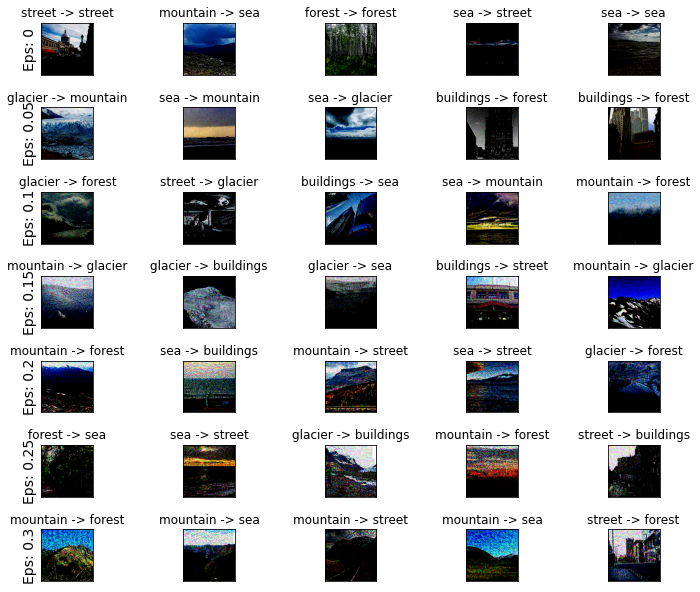

In [0]:
#getting label for visualize
labels={0:'buildings', 1:'forest', 2:'glacier', 3:'mountain', 4:'sea', 5:'street'}
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(10,20))
for i in range(len(epsilons[0:7])):
    for j in range(len(eg_trans[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(eg_trans[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = eg_trans[i][j]
        plt.title("{} -> {}".format(labels[orig], labels[adv]))
        ex = np.rollaxis(ex, 0, 3) #change the dimension from 3x150x150 to 150x150x3
        plt.imshow(ex)
        
plt.tight_layout()
plt.show()

### Defense Adversarial: Adversarial Training
We defended our network using the approach of adding a perturbation to the training data for 25% of the data. 

Why not 100% perturbation? We tried this out of interest and this did not achieve a better overall result, but worse. This is because if we perturbed the entire dataset, then we will not be giving the training enough normal samples. Therefore 25% was enough to notice an improvement. 

Where we could refine further, would be to identify the exact amount of perturbation required. 

The other effect of perturbing the training data was the "NO FREE LUNCH" scenario. In other words by training the model to the adversarial attack, it became less "good" at classifying in general. 


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import *


if torch.cuda.is_available():
    device = torch.device("cuda:0")  
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
    
#Image transformation and Data Augmentation
transform_train= transforms.Compose([transforms.Resize((150,150)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(degrees=20),
                                    transforms.ColorJitter(),
                                    transforms.CenterCrop(size=150),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#random hori flip is one kind of data augmentation, flip some random images horizontally 

transform_test= transforms.Compose([transforms.Resize((150,150)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#no need data augmentation for the testing data

#load images from the directories
train= datasets.ImageFolder('Data/seg_train', transform= transform_train)
test= datasets.ImageFolder('Data/seg_test', transform= transform_test)

#running data iterators
batch_size=128
train_loader= DataLoader(train,batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test,batch_size=1, shuffle=True)

Running on the GPU


In [0]:
from torchvision import models
def gen_model_def():
    model = models.alexnet(pretrained=True).to(device)
    #freeze model weights
    for param in model.parameters():
        param.requires_grad = False

    #adding custom classifier
    n_inputs= model.classifier[6].in_features #find out the number of inputs for our custom layer
    model.classifier[6]= nn.Sequential(
            nn.Linear(n_inputs, 4096), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(4096, 6), nn.LogSoftmax(dim=1))
    return model

trans_def= gen_model_def()
trans_def.classifier


Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=4096, out_features=6, bias=True)
    (4): LogSoftmax()
  )
)

In [0]:
epsilon= 0.1
epochs= 15
criterion= nn.NLLLoss()

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def training_def(model, eps):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.to(device)
    model.train()
    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            #let variables run on GPU
            x,y=x.to(device), y.to(device)
            # Set requires_grad attribute of tensor. Important for Attack
            x.requires_grad = True
            
            # Forward pass the data through the model
            yhat = model(x)

            # Calculate the loss
            loss = criterion(yhat, y)

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()
            #we are 
            if (i+1)%4==0:
                data_grad = x.grad.data
                perturbed_image = fgsm_attack(x, eps, data_grad)
                yhat = model(perturbed_image)

            else:
                yhat = model(x)
            
            loss = criterion(yhat, y)
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = y.size(0)
            predicted= torch.argmax(yhat, axis=1)
            correct = (predicted == y).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 55 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 100))

In [0]:
training_def(trans_def,epsilon)

Epoch [1/15], Step [55/110], Loss: 0.5414, Accuracy: 82.81%
Epoch [1/15], Step [110/110], Loss: 0.4758, Accuracy: 78.05%
Epoch [2/15], Step [55/110], Loss: 0.5581, Accuracy: 77.34%
Epoch [2/15], Step [110/110], Loss: 0.2825, Accuracy: 86.59%
Epoch [3/15], Step [55/110], Loss: 0.4834, Accuracy: 81.25%
Epoch [3/15], Step [110/110], Loss: 0.4977, Accuracy: 86.59%
Epoch [4/15], Step [55/110], Loss: 0.3325, Accuracy: 86.72%
Epoch [4/15], Step [110/110], Loss: 0.3388, Accuracy: 85.37%
Epoch [5/15], Step [55/110], Loss: 0.6058, Accuracy: 77.34%
Epoch [5/15], Step [110/110], Loss: 0.4546, Accuracy: 82.93%
Epoch [6/15], Step [55/110], Loss: 0.2616, Accuracy: 90.62%
Epoch [6/15], Step [110/110], Loss: 0.5834, Accuracy: 80.49%
Epoch [7/15], Step [55/110], Loss: 0.3494, Accuracy: 84.38%
Epoch [7/15], Step [110/110], Loss: 0.5748, Accuracy: 78.05%
Epoch [8/15], Step [55/110], Loss: 0.3168, Accuracy: 87.50%
Epoch [8/15], Step [110/110], Loss: 0.5593, Accuracy: 79.27%
Epoch [9/15], Step [55/110], Los

In [0]:
#defining test def function
def test_ad_def( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        #init_pred = init_pred.view(-1)
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {:.4f}".format(epsilon, correct, len(test_loader), final_acc))
    return final_acc, adv_examples

In [0]:
#accuracies and graph
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
df_trans= pd.read_csv('ad_atk_trans.csv')
acc_trans= df_trans['acc']
df_convo= pd.read_csv('ad_atk_convo.csv')
acc_convo= df_convo['acc']
epsilons = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65,.7, .75, .8]


def def_check(model,acc_norm):
    accuracies = []
    
    # Run test for each epsilon
    for eps in epsilons:
        acc, ex = test_ad_def(model, device, test_loader, eps)
        accuracies.append(acc)
    plt.plot(epsilons, acc_norm, "*-", label='Normal Model')
    plt.plot(epsilons, accuracies, "*-", color= 'orange', label='Adversarial Training')
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.xticks(np.arange(0, 1, step=0.1))
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.title('FGSM on Normal Model and Model with Adversarial Training')
    plt.legend(loc='best', fontsize=12)
    plt.show()


Epsilon: 0	Test Accuracy = 1946 / 3000 = 0.6487
Epsilon: 0.05	Test Accuracy = 1529 / 3000 = 0.5097
Epsilon: 0.1	Test Accuracy = 1577 / 3000 = 0.5257
Epsilon: 0.15	Test Accuracy = 1503 / 3000 = 0.5010
Epsilon: 0.2	Test Accuracy = 1444 / 3000 = 0.4813
Epsilon: 0.25	Test Accuracy = 1325 / 3000 = 0.4417
Epsilon: 0.3	Test Accuracy = 1312 / 3000 = 0.4373
Epsilon: 0.35	Test Accuracy = 1202 / 3000 = 0.4007
Epsilon: 0.4	Test Accuracy = 1176 / 3000 = 0.3920
Epsilon: 0.45	Test Accuracy = 1058 / 3000 = 0.3527
Epsilon: 0.5	Test Accuracy = 1006 / 3000 = 0.3353
Epsilon: 0.55	Test Accuracy = 986 / 3000 = 0.3287
Epsilon: 0.6	Test Accuracy = 945 / 3000 = 0.3150
Epsilon: 0.65	Test Accuracy = 888 / 3000 = 0.2960
Epsilon: 0.7	Test Accuracy = 841 / 3000 = 0.2803
Epsilon: 0.75	Test Accuracy = 819 / 3000 = 0.2730
Epsilon: 0.8	Test Accuracy = 817 / 3000 = 0.2723


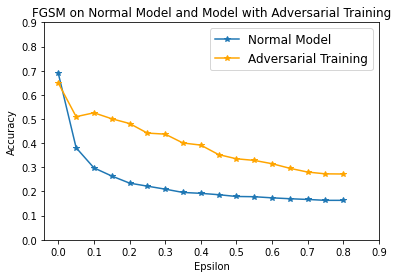

In [0]:
trans_def.to(device)
def_check(trans_def, acc_trans)

In [0]:
#no free lunch
def test_con(model):
    model.eval()
    correct = 0
    total = 0
    for key, dataset in {"Train set": train_loader, "Test set": test_loader}.items():
        with torch.no_grad():
            for (x,y) in dataset:
                x, y = x.to(device), y.to(device)
                output = model(x)
                for idx, i in enumerate(output):
                    if torch.argmax(i) ==y[idx]:
                        correct += 1
                    total += 1
        acc=(correct/total)*100
        print(f"Accuracy of {key}: {acc:.2f}%")
        
test_con(trans_def)

Accuracy of Train set: 90.36%
Accuracy of Test set: 89.96%


In [0]:
#not necessary to consider now
class convo(nn.Module):
    def __init__(self):
        super().__init__() 
       
        self.layer1= nn.Sequential(
            nn.Conv2d(3,128,kernel_size=5,stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        
        self.layer2= nn.Sequential(
            nn.Conv2d(128,256,kernel_size=5,stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        
        #self.dropout1= nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(16384, 1024)
        #self.dropout2= nn.Dropout2d(p=0.3)
        self.fc2 = nn.Linear(1024, 1024) 
        #self.dropout3= nn.Dropout2d(p=0.5)
        self.fc3 = nn.Linear(1024,6)
            
    def forward(self,x):
        x= self.layer1(x)
        x= self.layer2(x)
        #x= self.dropout1(x)
        x= x.reshape(x.size(0), -1)
        x= F.relu(self.fc1(x))
        #x= self.dropout2(x)
        x= F.relu(self.fc2(x))
        #x= self.dropout3(x)
        x= self.fc3(x)
        return F.log_softmax(x, dim=1)
    
convo_def= convo().to(device)

In [0]:
training_def(convo_def,epsilon)

Epoch [1/15], Step [55/110], Loss: 1.1178, Accuracy: 59.38%
Epoch [1/15], Step [110/110], Loss: 0.8540, Accuracy: 68.29%
Epoch [2/15], Step [55/110], Loss: 0.8383, Accuracy: 66.41%
Epoch [2/15], Step [110/110], Loss: 0.7654, Accuracy: 71.95%
Epoch [3/15], Step [55/110], Loss: 0.8266, Accuracy: 64.06%
Epoch [3/15], Step [110/110], Loss: 0.6864, Accuracy: 73.17%
Epoch [4/15], Step [55/110], Loss: 0.7102, Accuracy: 75.00%
Epoch [4/15], Step [110/110], Loss: 0.7205, Accuracy: 71.95%
Epoch [5/15], Step [55/110], Loss: 0.7234, Accuracy: 72.66%
Epoch [5/15], Step [110/110], Loss: 0.5239, Accuracy: 82.93%
Epoch [6/15], Step [55/110], Loss: 0.6580, Accuracy: 78.91%
Epoch [6/15], Step [110/110], Loss: 0.5718, Accuracy: 78.05%
Epoch [7/15], Step [55/110], Loss: 0.5275, Accuracy: 77.34%
Epoch [7/15], Step [110/110], Loss: 0.6405, Accuracy: 78.05%
Epoch [8/15], Step [55/110], Loss: 0.5903, Accuracy: 78.12%
Epoch [8/15], Step [110/110], Loss: 0.6409, Accuracy: 75.61%
Epoch [9/15], Step [55/110], Los

Epsilon: 0	Test Accuracy = 1451 / 3000 = 0.4837
Epsilon: 0.05	Test Accuracy = 1631 / 3000 = 0.5437
Epsilon: 0.1	Test Accuracy = 1728 / 3000 = 0.5760
Epsilon: 0.15	Test Accuracy = 1757 / 3000 = 0.5857
Epsilon: 0.2	Test Accuracy = 1754 / 3000 = 0.5847
Epsilon: 0.25	Test Accuracy = 1727 / 3000 = 0.5757
Epsilon: 0.3	Test Accuracy = 1686 / 3000 = 0.5620
Epsilon: 0.35	Test Accuracy = 1603 / 3000 = 0.5343
Epsilon: 0.4	Test Accuracy = 1532 / 3000 = 0.5107
Epsilon: 0.45	Test Accuracy = 1450 / 3000 = 0.4833
Epsilon: 0.5	Test Accuracy = 1378 / 3000 = 0.4593
Epsilon: 0.55	Test Accuracy = 1294 / 3000 = 0.4313
Epsilon: 0.6	Test Accuracy = 1239 / 3000 = 0.4130
Epsilon: 0.65	Test Accuracy = 1188 / 3000 = 0.3960
Epsilon: 0.7	Test Accuracy = 1142 / 3000 = 0.3807
Epsilon: 0.75	Test Accuracy = 1101 / 3000 = 0.3670
Epsilon: 0.8	Test Accuracy = 1077 / 3000 = 0.3590


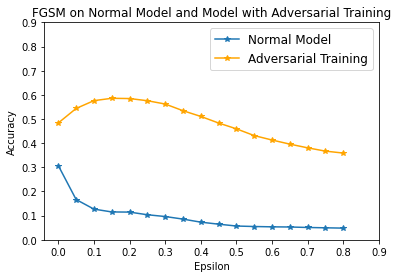

In [0]:
def_check(convo_def, acc_convo)

In [0]:
#no free lunch
def test_con(model):
    model.eval()
    correct = 0
    total = 0
    for key, dataset in {"Train set": train_loader, "Test set": test_loader}.items():
        with torch.no_grad():
            for (x,y) in dataset:
                x, y = x.to(device), y.to(device)
                output = model(x)
                for idx, i in enumerate(output):
                    if torch.argmax(i) ==y[idx]:
                        correct += 1
                    total += 1
        acc=(correct/total)*100
        print(f"Accuracy of {key}: {acc:.2f}%")
        
test_con(convo_def)

Accuracy of Train set: 87.38%
Accuracy of Test set: 86.26%


![alt text](https://scontent-lhr8-1.xx.fbcdn.net/v/t1.15752-9/90188732_2323295147971444_6365472709010259968_n.png?_nc_cat=107&_nc_sid=b96e70&_nc_ohc=AuA0Zsp2-FsAX8Tphbq&_nc_ht=scontent-lhr8-1.xx&oh=ec4b9ff61bdf4a91185518c1fab7a693&oe=5E946334)
*the image is created using Microsoft Excel*

## Conclusion: What did we find and Where will we go next?
In terms of our findings performed over two types of different models: Both our own CNN (model b) and the transfer_learning model (model c) had their own strengths and flaws under adversarial attack.

Although model c was superior in the adversarial attack, when trained, Model b responded far more positively to defensive training than Model c

Executive Summary for Adversarial Attacks between model a and model b (when defended):

For epsilon = 0 (no perturbation), the defended model c performed better.

For epsilon greater than 0 (when perturbed), the defended model b performed better. 
 

There are still other techniques for us to improve our models' performances. However, due to the time constrain and hardware issues we could not include and experiment all of them. Hence, these are things we would like to include in our future work:
- Early stopping
- Smaller increases in epsilon for example epsilon = 0.05 was not tested but epsilon = 0.1 was
- Identifying convergence between defended models under adversarial attack and the normal model
- Black box attacks
- Batch size normalisation
- Other data normalisation standards
- Transfer learning using other pre-trained models such as VGG16
- Different Epsilons in Adversarial Attack for the defense